<a href="https://colab.research.google.com/github/armandossrecife/teste/blob/main/Deep_Learning_Vision_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/val

In [4]:
!mkdir data/PetImages
!mkdir data/PetImages/Cat
!mkdir data/PetImages/Dog

In [6]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (102 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [7]:
!tree -L 3

.
├── data
│   ├── PetImages
│   │   ├── Cat
│   │   └── Dog
│   ├── train
│   └── val
└── sample_data
    ├── anscombe.json
    ├── california_housing_test.csv
    ├── california_housing_train.csv
    ├── mnist_test.csv
    ├── mnist_train_small.csv
    └── README.md

7 directories, 6 files


In [1]:
# config.py
import torch
from torchvision import transforms

class Config:
    # Data configuration
    DATA_URL = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
    DATA_DIR = 'data'
    TRAIN_DIR = 'data/train'
    VAL_DIR = 'data/val'
    MODEL_PATH = 'cat_dog_classifier.pth'

    # Training parameters
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 10

    # Image transformations
    IMAGE_SIZE = 224
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    # Device configuration
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def get_transform():
        return transforms.Compose([
            transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=Config.MEAN, std=Config.STD)
        ])

In [8]:
# model.py
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

class CatDogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)

        # Freeze layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace final layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

def initialize_model():
    """Initializes model, criterion and optimizer"""
    model = CatDogClassifier().to(Config.DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    return model, criterion, optimizer

In [9]:
#data_preparation.py
import os
import random
import shutil
import urllib.request
import zipfile
import logging
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import ssl

class DataHandler:
    @staticmethod
    def download_and_extract(url, data_dir):
        ssl._create_default_https_context = ssl._create_unverified_context
        """Downloads and extracts dataset"""
        try:
            os.makedirs(data_dir, exist_ok=True)
            filename = os.path.basename(url)
            filepath = os.path.join(data_dir, filename)

            if not os.path.exists(filepath):
                urllib.request.urlretrieve(url, filepath)

            if filepath.endswith('.zip'):
                with zipfile.ZipFile(filepath, 'r') as zip_ref:
                    zip_ref.extractall(data_dir)

            os.makedirs(os.path.join(data_dir, 'train'), exist_ok=True)
            os.makedirs(os.path.join(data_dir, 'val'), exist_ok=True)

        except Exception as e:
            logging.error(f"Data preparation error: {e}")
            raise

    @staticmethod
    def copy_random_files(source, dest, num_files, prefix):
        """Copies random files with prefix"""
        files = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
        files = random.sample(files, min(num_files, len(files)))

        os.makedirs(dest, exist_ok=True)
        for file in files:
            new_name = f"{prefix}.{file}"
            shutil.copy2(os.path.join(source, file), os.path.join(dest, new_name))

class CatDogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
            label = 0 if 'cat' in img_name.lower() else 1

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return self.__getitem__(torch.randint(0, len(self)-1, (1,)).item())

def prepare_data_loaders():
    """Prepares and returns train and validation data loaders"""
    transform = Config.get_transform()

    train_dataset = CatDogDataset(Config.TRAIN_DIR, transform)
    val_dataset = CatDogDataset(Config.VAL_DIR, transform)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

In [10]:
#train.py
import torch
from tqdm import tqdm

def train_epoch(model, loader, criterion, optimizer):
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)# Step 6: Training Setup

    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc="Training"):
        images = images.to(Config.DEVICE)
        labels = labels.float().unsqueeze(1).to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images = images.to(Config.DEVICE)
            labels = labels.float().unsqueeze(1).to(Config.DEVICE)

            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0)
            correct += ((outputs > 0.5).float() == labels).sum().item()

    accuracy = 100 * correct / len(loader.dataset)
    return val_loss / len(loader.dataset), accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(Config.NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{Config.NUM_EPOCHS}")

        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return history

In [11]:
#evaluate.py
import torch
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    """Predicts whether image is cat or dog"""
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            output = model(image)
            prob = output.item()
            pred = 'dog' if prob > 0.5 else 'cat'

        return pred, prob
    except Exception as e:
        print(f"Prediction error: {e}")
        return None, None

def visualize_predictions(image_paths, model, transform, device):
    """Visualizes predictions for multiple images"""
    plt.figure(figsize=(15, 10))
    for i, path in enumerate(image_paths):
        image = Image.open(path).convert('RGB')
        pred, prob = predict_image(path, model, transform, device)

        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f"{pred} ({prob:.2f})")
        plt.axis('off')
    plt.show()

def plot_training_history(history):
    """Plots training and validation metrics"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

In [12]:
#main.py
def main():
    try:
      # Step 1: Prepare data
      print("Step 1: Prepare data")
      DataHandler.download_and_extract(Config.DATA_URL, Config.DATA_DIR)

      # Copy sample files (you would call these with your actual paths)
      print("Copy sample files to training")
      DataHandler.copy_random_files("data/PetImages/Cat", Config.TRAIN_DIR, 1000, 'cat')
      DataHandler.copy_random_files("data/PetImages/Dog", Config.TRAIN_DIR, 1000, 'dog')

      # Similar for validation...
      # Copy sample files (you would call these with your actual paths)
      print("Copy sample files to validate")
      DataHandler.copy_random_files("data/PetImages/Cat", Config.VAL_DIR, 1000, 'cat')
      DataHandler.copy_random_files("data/PetImages/Dog", Config.VAL_DIR, 1000, 'dog')

      print("prepare_data_loaders")
      train_loader, val_loader = prepare_data_loaders()

      # Step 2: Initialize model
      print("Step 2: Initialize model")
      model, criterion, optimizer = initialize_model()

      # Step 3: Train model
      print("Step 3: Train model")
      history = train_model(model, train_loader, val_loader, criterion, optimizer)

      # Step 4: Save model
      print("Step 4: Save model")
      torch.save(model.state_dict(), Config.MODEL_PATH)

      # Step 5: Evaluate
      print("Step 5: Evaluate")
      plot_training_history(history)

      # Example predictions
      print("Example predictions")
      test_images = [
          'data/PetImages/Dog/1.jpg',
          'data/PetImages/Cat/1000.jpg'
      ]
      visualize_predictions(test_images, model, Config.get_transform(), Config.DEVICE)
    except Exception as ex:
      print(f"Erro na chamada principal: {str(ex)}")

Step 1: Prepare data
Copy sample files to training
Copy sample files to validate
prepare_data_loaders
Step 2: Initialize model


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 92.8MB/s]


Step 3: Train model

Epoch 1/10


Validating: 100%|██████████| 63/63 [03:18<00:00,  3.16s/it]


Train Loss: 0.3256 | Val Loss: 0.1714 | Val Acc: 95.70%

Epoch 2/10


Validating: 100%|██████████| 63/63 [03:20<00:00,  3.18s/it]


Train Loss: 0.1604 | Val Loss: 0.1281 | Val Acc: 96.60%

Epoch 3/10


Validating: 100%|██████████| 63/63 [03:26<00:00,  3.27s/it]


Train Loss: 0.1325 | Val Loss: 0.1026 | Val Acc: 97.10%

Epoch 4/10


Validating: 100%|██████████| 63/63 [03:21<00:00,  3.20s/it]


Train Loss: 0.1124 | Val Loss: 0.0904 | Val Acc: 97.20%

Epoch 5/10


Validating: 100%|██████████| 63/63 [03:21<00:00,  3.20s/it]


Train Loss: 0.1077 | Val Loss: 0.1066 | Val Acc: 96.30%

Epoch 6/10


Validating: 100%|██████████| 63/63 [03:20<00:00,  3.18s/it]


Train Loss: 0.1155 | Val Loss: 0.0768 | Val Acc: 97.65%

Epoch 7/10


Validating: 100%|██████████| 63/63 [03:20<00:00,  3.19s/it]


Train Loss: 0.0891 | Val Loss: 0.0757 | Val Acc: 97.25%

Epoch 8/10


Validating: 100%|██████████| 63/63 [03:21<00:00,  3.19s/it]


Train Loss: 0.1006 | Val Loss: 0.0690 | Val Acc: 97.40%

Epoch 9/10


Validating: 100%|██████████| 63/63 [03:19<00:00,  3.17s/it]


Train Loss: 0.0791 | Val Loss: 0.0721 | Val Acc: 97.10%

Epoch 10/10


Validating: 100%|██████████| 63/63 [03:18<00:00,  3.16s/it]


Train Loss: 0.0738 | Val Loss: 0.0642 | Val Acc: 97.55%
Step 4: Save model
Step 5: Evaluate


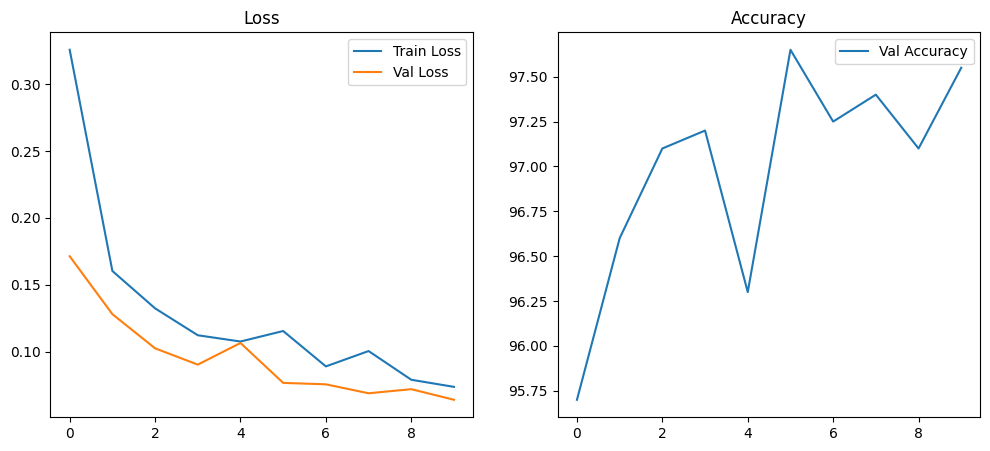

Example predictions


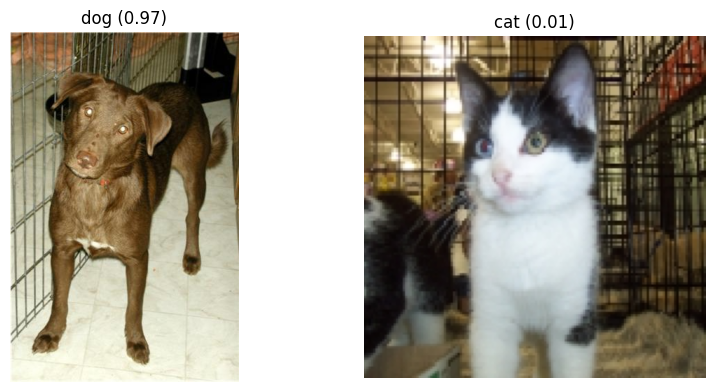

In [13]:
main()